### Value at Risk

### Monte Carlo Method:

#### Importing Libraries:

In [9]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
import time
import pandas_datareader.data as web


#### Set time from to a certain number of years: 


In [3]:
years = 15 

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365 * years)

#### The tickers:

In [4]:
tickers = ['NVDA', 'AMZN', 'GLD', 'GOOGL', 'ORCL']

#### Downloading the daily adjusted closed prices: 

Adjusted closed prices account for dividend and stock splits to make analysis more accurate. 

Here stooq is good for development and testing and stuff but yfinance is a bit more accurate, for final results try to use yfinance

In [ ]:
adj_close_df = web.DataReader(
    tickers,
    "stooq",
    startDate,
    endDate
)["Close"]

adj_close_df = adj_close_df.sort_index()
print(adj_close_df)


Symbols           NVDA      AMZN     GLD     GOOGL      ORCL
Date                                                        
2011-01-06    0.443228    9.2930  133.83   15.2821   26.3758
2011-01-07    0.455681    9.2745  133.58   15.3553   26.2570
2011-01-10    0.472964    9.2340  134.12   15.2996   26.2669
2011-01-11    0.465675    9.2170  134.91   15.3443   26.2213
2011-01-12    0.535382    9.2040  135.46   15.3663   26.1867
...                ...       ...     ...       ...       ...
2025-12-26  190.530000  232.5200  416.74  313.5100  197.9900
2025-12-29  188.220000  232.0700  398.60  313.5600  195.3800
2025-12-30  187.540000  232.5300  398.89  313.8500  197.2100
2025-12-31  186.500000  230.8200  396.31  313.0000  194.9100
2026-01-02  188.850000  226.5000  398.28  315.1500  195.7100

[3770 rows x 5 columns]


#### Calculate the daily log returns and drop NAs:

In [11]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

print(log_returns)

Symbols         NVDA      AMZN       GLD     GOOGL      ORCL
Date                                                        
2011-01-07  0.027709 -0.001993 -0.001870  0.004778 -0.004514
2011-01-10  0.037226 -0.004376  0.004034 -0.003634  0.000377
2011-01-11 -0.015531 -0.001843  0.005873  0.002917 -0.001738
2011-01-12  0.139493 -0.001411  0.004069  0.001433 -0.001320
2011-01-13  0.001767  0.007846 -0.010464 -0.000293  0.007499
...              ...       ...       ...       ...       ...
2025-12-26  0.010128  0.000602  0.011609 -0.001848  0.002529
2025-12-29 -0.012198 -0.001937 -0.044504  0.000159 -0.013270
2025-12-30 -0.003619  0.001980  0.000727  0.000924  0.009323
2025-12-31 -0.005561 -0.007381 -0.006489 -0.002712 -0.011731
2026-01-02  0.012522 -0.018893  0.004959  0.006846  0.004096

[3767 rows x 5 columns]


#### Create a function that will be used to calculate portfolio expected return:

We are assuming that future returns are based on past returns, which is not a reliable assumption.

If we want to make it more accurate we will need to come up with our own expected returns or pay for an eqiuty research firm... rather than using the historical returns to base the future returns on...

In [18]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)

#### Create a function that will be used to calculate the portfolio std deviation:

In [19]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

#### Create a covariance matrix for all the securities: 

In [12]:
cov_matrix = log_returns.cov()
print(cov_matrix)

Symbols      NVDA      AMZN       GLD     GOOGL      ORCL
Symbols                                                  
NVDA     0.000816  0.000284  0.000005  0.000252  0.000236
AMZN     0.000284  0.000426  0.000002  0.000213  0.000143
GLD      0.000005  0.000002  0.000099  0.000005  0.000005
GOOGL    0.000252  0.000213  0.000005  0.000302  0.000132
ORCL     0.000236  0.000143  0.000005  0.000132  0.000361


#### Create an equally weighted portfolio expected return and standard deviation:

In [20]:
portfolio_value = 1000 

weights = np.array([1/len(tickers)] * len(tickers))

portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation(weights, cov_matrix)

#### Create a function to give a random Z-score based on normal distribution:

In [23]:
def random_z_score():
    return np.random.normal(0,1)

#### Create a function to calculate scenarioGainLoss:

In [21]:
days = 5

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return (portfolio_value * portfolio_expected_return * days ) + (portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)) 

#### Run 10,0000 Simulations:

In [24]:
simulations = 100000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

#### Specify a confidence interval and calculate value at risk (VaR):

In [29]:
confidence_interval = 0.95

VaR = - np.percentile(scenarioReturn, 100*(1-confidence_interval))

print(VaR)

45.17736433727392


#### Plotting the results of all 10,000 scenarios: 


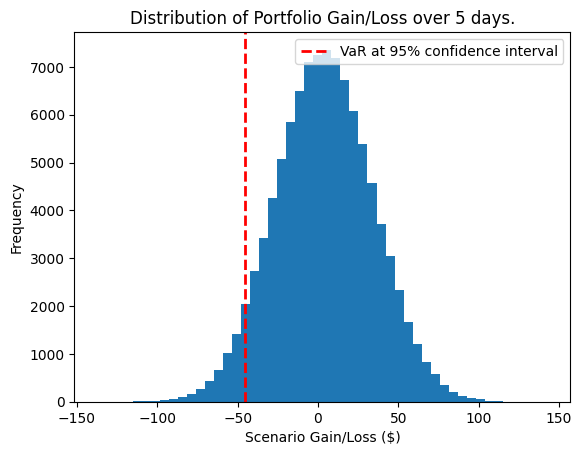

In [31]:
plt.hist(scenarioReturn, bins=50 , density = False)
plt.xlabel("Scenario Gain/Loss ($)")
plt.ylabel("Frequency")
plt.title(f"Distribution of Portfolio Gain/Loss over {days} days.")
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence interval')
plt.legend()
plt.show()